In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Mean(pmf):
    total = 0
    for hypo, prob in pmf.items():
        total += hypo * prob
    return total

def Percentile(pmf, percentage):
    p = percentage / 100.0
    total = 0
    for hypo, prob in pmf.items():
        total += prob
        if total >= p:
            return hypo
        
def MakeCdf(pmf):
    """
    pmf is a dict of hypotheses and probabilities. pmf should be sorted in a logical order
    
    Returns a dict of hypotheses and cumulative probabilities.
    """
    
    hypos, probs = zip(*pmf.items())
    cumprobs = np.cumsum(probs)
    cdf = {hypo:cumprob for hypo, cumprob in zip(hypos, cumprobs)}
    
    return cdf    

def MaximumLikelihood(pmf):
    "Returns the value with the highest probability"
    prob, hypo = max((prob, hypo) for (hypo, prob) in pmf.items())
    return hypo

In [121]:
class Pmf(object):
    
    def __init__(self, hypotheses):
        """
        `hypos` is a list of labels for hypotheses of a given problem,
        currently this ignore a uniform prior
        """
        self.hypotheses = {}
        for hypothesis in hypotheses:
            if hypothesis in self.hypotheses.keys():
                self.hypotheses[hypothesis] += 1
            else:
                self.hypotheses[hypothesis] = 1
        self.normalize()
        self.prior = self.hypotheses.copy()
        
    def normalize(self):
        """
        Normalize the total probabilities to add up to 100%
        """
        total = sum(self.hypotheses.values())
        for hypothesis in self.hypotheses:
            self.hypotheses[hypothesis] = self.hypotheses[hypothesis] / total 
            
    def update(self, data):
        """
        Update the probability distribution by multiplying the prior 
        by the likelihood and then normalizing
        """
        for hypothesis in self.hypotheses:
            like = self.likelihood(data, hypothesis)
            self.hypotheses[hypothesis] = self.hypotheses[hypothesis] * like
        self.normalize()
        
    def plot_prior_and_posterior(self):
        hypos_prior, probs_prior = zip(*self.prior.items())
        hypos_posterior, probs_posterior = zip(*self.hypotheses.items())
        
        p = plt.plot(hypos_prior, probs_prior, label = 'prior')
        p = plt.plot(hypos_posterior, probs_posterior, label = 'posterior')
        
        return p

The Cookie Problem:

There are two bowls
Bowl 1: 30 vanilla and 10 chocolate
Bowl 2: 20 vanilla and 20 chocolate

You pick one cookie and it is vanilla, what is the probability it is from Bowl 1?

Likelihood for Bowl 1 = P(Vanilla|Bowl 1) = 0.75 <br>
Likelihood for Bowl 2 = P(Vanilla|Bowl 2) = 0.5

In [122]:
class Bowl(object):
    
    def __init__(self, num_vanilla, num_chocolate):
        self.mix = dict(vanilla=num_vanilla, chocolate=num_chocolate)
        

class Cookie(Pmf):
    
    def __init__(self, hypotheses, replace = True):
        Pmf.__init__(self, hypotheses)
        self.mixes = {
                        'Bowl 1': dict(vanilla = 0.75, chocolate= 0.25),
                        'Bowl 2': dict(vanilla = 0.5, chocolate= 0.5)
                     }
        self.replace = replace
        
    def likelihood(self, data, hypo):
        """
        Compute the likelihood which is the probability we will see the data
        given the specific hypothesis.
        
        Data could be either 'vanilla' or 'chocolate' and hypothesis could be
        'Bowl 1' or 'Bowl 2'
        """
        like = self.mixes[hypo][data]
        return like
    
    
class Cookie(Pmf):
    
    def __init__(self, hypotheses, replace = True):
        Pmf.__init__(self, hypotheses)
        self.mixes = {
                        'Bowl 1': Bowl(num_vanilla=30, num_chocolate=10),
                        'Bowl 2': Bowl(num_vanilla=20, num_chocolate=20)
                     }
        self.replace = replace
        
    def likelihood(self, data, hypo):
        """
        Compute the likelihood which is the probability we will see the data
        given the specific hypothesis.
        
        Data could be either 'vanilla' or 'chocolate' and hypothesis could be
        'Bowl 1' or 'Bowl 2'
        """
        bowl = self.mixes[hypo]
        data_cookie = bowl.mix[data]
        total_cookies = sum(bowl.mix.values())
        
        if self.replace == False:
            bowl.mix[data] -= 1
        
        like = data_cookie / total_cookies
        return like

In [123]:
hypotheses = ['Bowl 1', 'Bowl 2']

X = Cookie(hypotheses, replace = False)
X.update('vanilla')
print(X.hypotheses)

X = Cookie(hypotheses, replace = False)
dataset = ['vanilla', 'chocolate', 'vanilla']
for data in dataset:
    X.update(data)
print(X.hypotheses)

{'Bowl 1': 0.6, 'Bowl 2': 0.4}
{'Bowl 1': 0.5337423312883435, 'Bowl 2': 0.46625766871165636}


Monty Hall problem:

There are three doors, there is a car behind one door and no prize behind the other two. You pick door A and then Monty opens a different door that doesn't have a car behgind it.

What is the probability it is behind each door?

In [124]:
class Monty(Pmf):
    
    def likelihood(self, data, hypo):
        """
        Given a data point and a hypothesis, get the likelihood of the data given the hypothesis
        by looking at the `mixes` variable. 
        
        In this case the data point is the door that Monty opens to reveal nothing behind it
        """
        if hypo == data:
            "The likelihood of Monty opening the door with the car is 0"
            return 0
        elif hypo == 'A':
            "The likelihood of Monty opening one of the other doors given the car is behind Door A is 0.5"
            return 0.5
        else:
            """
            If the car is not behind the Door we chose (and we know it's not behind the Door Monty opened)
            then there is a 100% probability it is behind the door Monty did not open (i.e. not Door A and 
            not the door he opened)
            """ 
            return 1
        return like

In [125]:
# choose Door A, Monty opens door B
hypotheses = ['A', 'B', 'C']

X = Monty(hypotheses)
X.update('B')
print(X.hypotheses)

{'A': 0.3333333333333333, 'B': 0.0, 'C': 0.6666666666666666}


The M&M Problem:

In 1995 blue M&M's were first introduced. 

Pre-1995 mix:  30% Brown, 20% Yellow, 20% Red, 10% Green, 10% Orange, 10% Tan
Post-1995 mix:  24% Blue, 20% Green, 16% Orange, 14% Yellow, 13% Red, 13% Brown

There is one bag of M&Ms from 1994 and one from 1996, but we don't know which is which. We take one M&M from each bag.
Bag 1: pulled a yellow
Bag 2: pulled a green

What is the probability the yellow one came from 1994 bag? I.e, what is the probability Bag 1 is from 1994?

Hypotheses:
A: Bag 1 is 1994, Bag 2 is 1996
B: Bag 1 is 1996, Bag 2 is 1994

In [126]:
class M_and_M(Pmf):
    """
    Hypothesis 
        hypo1:  Bag 1 is 1994 and Bag 2 is 1996
        hypo2:  Bag 1 is 1996 and Bag 2 is 1994
    """
    def __init__(self, hypotheses):
        Pmf.__init__(self, hypotheses)
        mix94 = dict(
                            brown = 30,
                            yellow = 20,
                            red = 20,
                            green = 10
                            , orange = 10
                            , tan = 10
                        )
        mix96 = dict(
                            blue=24,
                            green=20,
                            orange=16,
                            yellow=14,
                            red=13,
                            brown=13
                        )
        hypo1 = dict(bag1 = mix94, bag2 = mix96)
        hypo2 = dict(bag1 = mix96, bag2 = mix94)
        self.hypos = dict(hypoA=hypo1, hypoB=hypo2)
        
    def likelihood(self, data, hypo):
        """
        Compute the likelihood which is the probability we will see the data
        given the specific hypothesis.
        
        Data could be a combo of a bag and a color like 'bag1, green' or 'bag2, brown', hypothesis is either:
            - hypo1: bag1 is '94 and bag2 is '96
            - hypo2: bag1 is '96 and bag2 is '94
            
        If the data is 'green' and the hypothesis is 'hypo1', then the likelihood is 
        the probability of getting a green given bag1 is mix94 and bag2 is mix96
        """
        bag, color = data
        like = self.hypos[hypo][bag][color]
        return like

In [127]:
X = M_and_M(['hypoA', 'hypoB'])
X.update(('bag1', 'yellow'))
X.update(('bag2', 'green'))
print(X.hypotheses)

{'hypoA': 0.7407407407407408, 'hypoB': 0.25925925925925924}


Dice Problem: I have a box of dice that contains a 4-sided die, a 6-sided die, an
8-sided die, a 12-sided die, and a 20-sided die. 

I select one die from the box and get a '6', what is the probability I rolled each die?

In [128]:
class Dice(Pmf):
    
    def likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0 / hypo

In [130]:
hypotheses = [4, 6, 8, 12, 20]

X = Dice(hypotheses)
X.update(6)
print(X.hypotheses)

dataset = [6, 8, 7, 7, 5, 4]
for data in dataset:
    X.update(data)
print(X.hypotheses)

{4: 0.0, 6: 0.3921568627450981, 8: 0.2941176470588236, 12: 0.19607843137254904, 20: 0.11764705882352945}
{4: 0.0, 6: 0.0, 8: 0.9432484536722127, 12: 0.055206128061290875, 20: 0.0015454182664965536}


The Locomotive Problem:

A railroad numbers its locomotives in order 1..N. One day you
see a locomotive with the number 60. Estimate how many locomotives the railroad has.

The hypothesis is the number of locomotives in existence. The likelihood is the probability of seeing the #60 on a train given a specific number of locomotives which would be 1 out of the hypothesis.

In [131]:
class Train(Pmf):
    
    def likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1 / hypo


# for the prior, assume an equal likelihood from 1 to 1000
num_trains = 500
hypotheses = np.arange(1, num_trains+1)
X = Train(hypotheses)

dataset = [60, 30, 90]
for data in dataset:
    X.update(data)

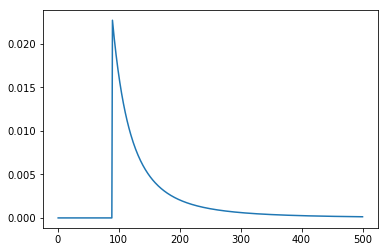

151.84958795903825

In [132]:
values, probabilities = zip(*X.hypotheses.items())
plt.plot(values, probabilities)
plt.show()

Mean(X.hypotheses)

Locomotive problem with a power law prior

$$PMF(x)=\left(\frac{1}{x}\right)^a$$

Where $PMF(x)$ is the probability mass function of x (# of locomotives) and $\alpha$ is a parameter for the power law

In [133]:
class Train(Pmf):
    """
    Overwrote the __init__ function to use a power law instead of a uniform prior
    """
    def __init__(self, hypotheses, alpha=1.0):
        self.hypotheses = {}
        for hypothesis in hypotheses:
            self.hypotheses[hypothesis] = (hypothesis)**(-alpha)
        self.normalize()
        self.prior = self.hypotheses.copy()
    
    def likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1 / hypo

In [134]:
num_trains = 10
alpha = 1.0
hypotheses = np.arange(1, num_trains+1)

X = Train(hypotheses)
prior = X.hypotheses

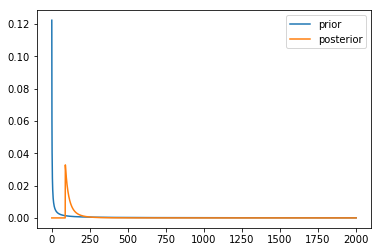

133.99746308073063
(91, 243)


In [135]:
# for the prior, use a power law with alpha = 1.0
num_trains = 2000
alpha = 1.0
hypotheses = np.arange(1, num_trains+1)
X = Train(hypotheses, alpha=alpha)
prior = X.hypotheses

dataset = [60, 30, 90]
for data in dataset:
    X.update(data)

X.plot_prior_and_posterior()
plt.legend(loc='best')
plt.show()

interval = Percentile(X.hypotheses, 5), Percentile(X.hypotheses, 95)
print(Mean(X.hypotheses))
print(interval)

Euro problem:

When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.

What is the probability the coin is fair?

A hypothesis is the probability of a heads. A data point is whether the coin lands heads or tails. the likelihood function is the probability of getting a heads or tails given a specific hypothesis for the probability of a heads.

In [136]:
class Euro(Pmf):
    
    def likelihood(self, data, hypo):
        """
        Given a hypothesis p where p is the probability of heads, the likelihood we
        would get the 'data' (H or T) is p if it's H or 1 - p if it's T
        """
        if data == 'H':
            return hypo
        else:
            return 1 - hypo

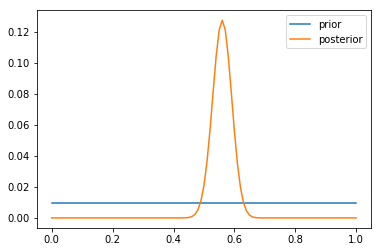

Maximum Likelihood: 0.56
Mean: 0.5595238095238094
Median: 0.56
Interval: 0.51 -- 0.61


In [137]:
hypotheses = np.linspace(0, 1, 101) 
X = Euro(hypotheses)

dataset = ['H'] * 140 + ['T'] * 110
for data in dataset:
    X.update(data)

X.plot_prior_and_posterior()
plt.legend(loc='best')
plt.show()

print('Maximum Likelihood:', MaximumLikelihood(X.hypotheses))
print('Mean:', Mean(X.hypotheses))
print('Median:', Percentile(X.hypotheses, 50))
print('Interval:', Percentile(X.hypotheses, 5), '--', Percentile(X.hypotheses, 95))

In [138]:
class Euro(Pmf):
    
    def __init__(self):
        hypotheses = np.linspace(0, 1, 101)
        self.hypotheses = {}
        for hypothesis in hypotheses:
            if hypothesis <= .50:
                self.hypotheses[hypothesis] = hypothesis
            else:
                self.hypotheses[hypothesis] = 1 - hypothesis
        self.normalize()
        self.prior = self.hypotheses.copy()
        
    
    def likelihood(self, data, hypo):
        """
        Given a hypothesis p where p is the probability of heads, the likelihood we
        would get the 'data' (H or T) is p if it's H or 1 - p if it's T
        """
        if data == 'H':
            return hypo
        else:
            return 1 - hypo

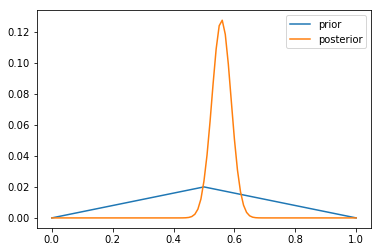

Maximum Likelihood: 0.56
Mean: 0.5574349943859505
Median: 0.56
Interval: 0.51 -- 0.61


In [139]:
# hypotheses = np.linspace(0, 1, 101) 
X = Euro()

dataset = ['H'] * 140 + ['T'] * 110
for data in dataset:
    X.update(data)

X.plot_prior_and_posterior()
plt.legend(loc='best')
plt.show()

print('Maximum Likelihood:', MaximumLikelihood(X.hypotheses))
print('Mean:', Mean(X.hypotheses))
print('Median:', Percentile(X.hypotheses, 50))
print('Interval:', Percentile(X.hypotheses, 5), '--', Percentile(X.hypotheses, 95))

In [140]:
class Beta(object):
    
    def __init__(self, alpha=1.0, beta=1.0):
        self.alpha = alpha
        self.beta = beta
        
    def update(self, data):
        """
        'data' is a tuple of integers (num_heads, num_tails)
        
        Returns an updated alpha and beta. To update a beta distribution, 
        you simply add num_heads to alpha and num_tails to beta.
        """
        heads, tails = data
        self.alpha += heads
        self.beta += tails
        
    def mean(self):
        """
        Return the mean of the distribution which represents the probability of heads. 
        This can be found by finding the fraction of heads compared to the total flips (heads and tails)
        """
        return float(self.alpha) / (self.alpha + self.beta)
    
    def pdf(self, hypo):
        """
        For a given hypothesis 'hypo' return the value of the probability density function
        for the beta distribution
        """
        return (hypo**(self.alpha - 1)) * ((1-hypo)**(self.beta - 1))

In [141]:
X = Beta()
data = (140, 110)
X.update(data)
X.mean()

0.5595238095238095

Dice problem:

Roll three 6-sided die and add up the some. What is the distribution of this sum?

In [157]:
class Die(Pmf):
    def __init__(self, sides):
        """
        `hypos` is a list of labels for hypotheses of a given problem,
        currently this ignore a uniform prior
        """
        self.hypotheses = {}
        for side in range(1, sides+1):
            self.hypotheses[side] = 1
        self.normalize()
        self.prior = self.hypotheses.copy()        

def sampleSum(pmfs, n):
    """
    Given pmfs (dicts of vals and probabilities, where the vals are numeric (e.g. sides of a die)),
    randomly choose from each pmf (e.g. roll each dice) and add up the sum. 
    Do that n times and calculate a pmf from the results.
    """
    
    # choose from each pmf (e.g. each dice) and add up the total
    totals = []
    for i in range(n):
        total = 0
        for pmf in pmfs:
            total += randomChoice(pmf)
        totals.append(total)
    
    totals_pmf = Pmf(totals)
    
    return totals_pmf

def randomChoice(pmf):
    """
    Given a pmf (dict of vals and probabilities, where the vals are numeric (e.g. sides of a die)),
    randomly choose one of the vals
    """
    roll = np.random.choice([k for k in pmf.hypotheses.keys()], p = [p for p in pmf.hypotheses.values()])
    return roll

def combine_pmfs(pmfs):
    """
    Given pmfs (dicts of vals and probabilities, where the vals are numeric (e.g. sides of a die)),
    combine all three pmfs into 1 by adding them together
    """

    pmf_1 = pmfs[0] # start with the first pmf
    num_pmfs = len(pmfs)
    for i in range(1,num_pmfs):
        result_pmf = {}
        other_pmf = pmfs[i]
        for v1, p1, in pmf_1.items():
            for v2, p2 in other_pmf.items():
                if v1+v2 in result_pmf.keys():
                    result_pmf[v1+v2] += p1*p2
                else:
                    result_pmf[v1+v2] = p1*p2
                    
        pmf_1 = result_pmf.copy()
        
    
    return result_pmf

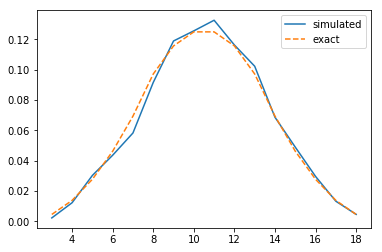

In [332]:
d6 = Die(6)
dice = [d6] * 3
X = sampleSum(dice, 3000)
simulation_pdf = X.hypotheses

dice_pmfs = [d.hypotheses for d in dice]
enumeration_pdf = combine_pmfs(dice_pmfs)

hypos, probs = zip(*sorted(simulation_pdf.items()))
plt.plot(hypos, probs, label = 'simulated')
hypos, probs = zip(*sorted(enumeration_pdf.items()))
plt.plot(hypos, probs, label = 'exact', ls = '--')

plt.legend(loc='best')
plt.show()

Dice problem continued:

When you play Dungeons and Dragons, you roll three dice for each of 6 attributes. We are interested in distribution of the maximum of all six of our 3-dice rolls. Concretely, we "occurence" is doing a 3-die roll six times and seeing what the maximum of the six time,. 

In [156]:
np.sum([t == 5 for t in totals])

34

In [119]:
if 1 in X.hypotheses.keys():
    print('yo')
else:
    print('nope')

nope


In [120]:
X.hypotheses.keys()

dict_keys([9, 12, 10, 4, 11, 14, 7, 13, 17, 8, 3, 6, 15, 16, 5, 18, 2])

In [90]:
for i in range(5):
    print(i)

0
1
2
3
4


In [39]:
import random

In [40]:
random.random()

0.7284128427028486

In [57]:
np.random.choice([k for k in d6.hypotheses.keys()], p = [p for p in d6.hypotheses.values()])

4

In [58]:
d6.hypotheses.values()

dict_values([0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666])